In [1]:
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.2/205.2 kB 458.7 kB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx
/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv


In [3]:
#Importing all the libraries that I use in this project
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from flaml import AutoML
import lightgbm as lgb
from imblearn.over_sampling import SMOTEN

In [4]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 120,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "pcos.log",
}

In [5]:
#Loding data into the kernels 

file_path_with_infertility="../input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv"
file_path_without_infertility="../input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

In [6]:
PCOS_inf.head()

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [7]:
PCOS_woinf.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1.0,1.0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,...,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5,NaN
1,2.0,2.0,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,...,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7,NaN
2,3.0,3.0,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,...,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0,NaN
3,4.0,4.0,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,...,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5,NaN
4,5.0,5.0,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,...,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0,NaN


In [8]:
#Merging the two files as per patient file no. 
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes=('','_y'),how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head() 

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1.0,1.0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,...,0.0,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5
1,2.0,2.0,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,...,0.0,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7
2,3.0,3.0,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,...,1.0,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0
3,4.0,4.0,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,...,0.0,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5
4,5.0,5.0,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,...,0.0,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    float64
 1   Patient File No.        541 non-null    float64
 2   PCOS (Y/N)              541 non-null    float64
 3    Age (yrs)              541 non-null    float64
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    float64
 8   Pulse rate(bpm)         541 non-null    float64
 9   RR (breaths/min)        541 non-null    float64
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    float64
 12  Cycle length(days)      541 non-null    float64
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    fl

In [10]:
#Having a look at the data with dtype objects

data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [11]:
#Similarly

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [12]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values. 
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

In [13]:
# Having a look at some basic statistical details.

data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [14]:
#Added in the recent update. 
#This came upon evaluating the dataset some obvious outliers I am not explaining the process I used. 
#Dropping the outliers. 

data = data[(data["BP _Diastolic (mmHg)"]>20)]
data = data[(data["AMH(ng/mL)"]<40)]
data = data[(data["BP _Systolic (mmHg)"]>20)]
data = data[(data["Endometrium (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["RBS(mg/dl)"]<200)]
data = data[(data["PRG(ng/mL)"]<20)]
data = data[(data["Pulse rate(bpm)"]>20)]
data = data[(data["FSH(mIU/mL)"]<4000)]
data = data[(data["LH(mIU/mL)"]<1500)]
data = data[(data["Cycle(R/I)"]<4.5)]

data.shape

(526, 44)

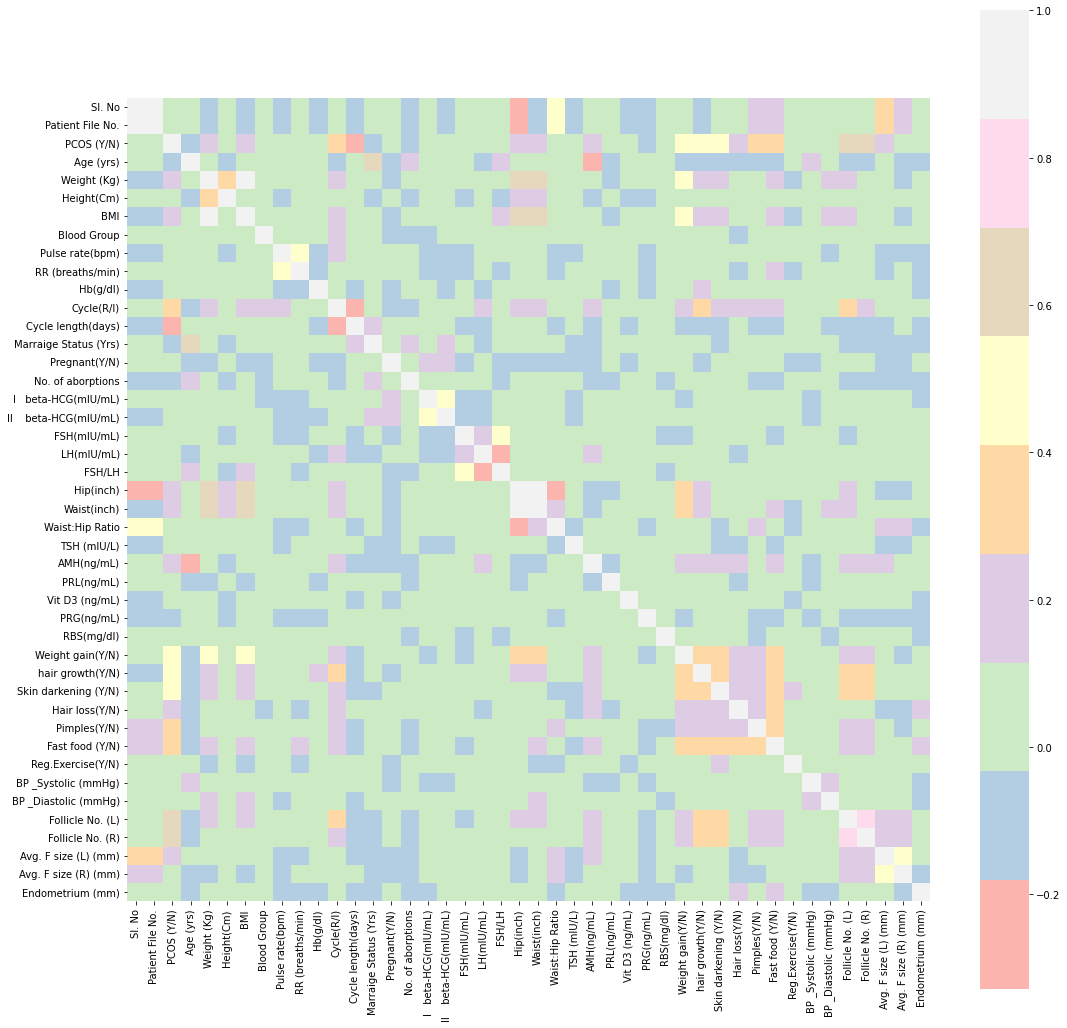

In [15]:
#Examaning a correlation matrix of all the features 

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Pastel1", square=True);

In [16]:
#How all the features correlate with the PCOS 

corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650915
Follicle No. (L)          0.605305
Skin darkening (Y/N)      0.474561
hair growth(Y/N)          0.463557
Weight gain(Y/N)          0.445646
Cycle(R/I)                0.404082
Fast food (Y/N)           0.376877
Pimples(Y/N)              0.295313
AMH(ng/mL)                0.261105
Weight (Kg)               0.210241
BMI                       0.194121
Hair loss(Y/N)            0.176603
Hip(inch)                 0.163335
Waist(inch)               0.160226
Avg. F size (L) (mm)      0.124990
Pulse rate(bpm)           0.102988
LH(mIU/mL)                0.095426
Hb(g/dl)                  0.094481
Vit D3 (ng/mL)            0.086052
Endometrium (mm)          0.085608
Avg. F size (R) (mm)      0.084756
Height(Cm)                0.075431
Reg.Exercise(Y/N)         0.061816
Sl. No                    0.051936
Patient File No.          0.051936
FSH/LH                    0.043591
Blood Group               0.043032
RR (breaths/min)    

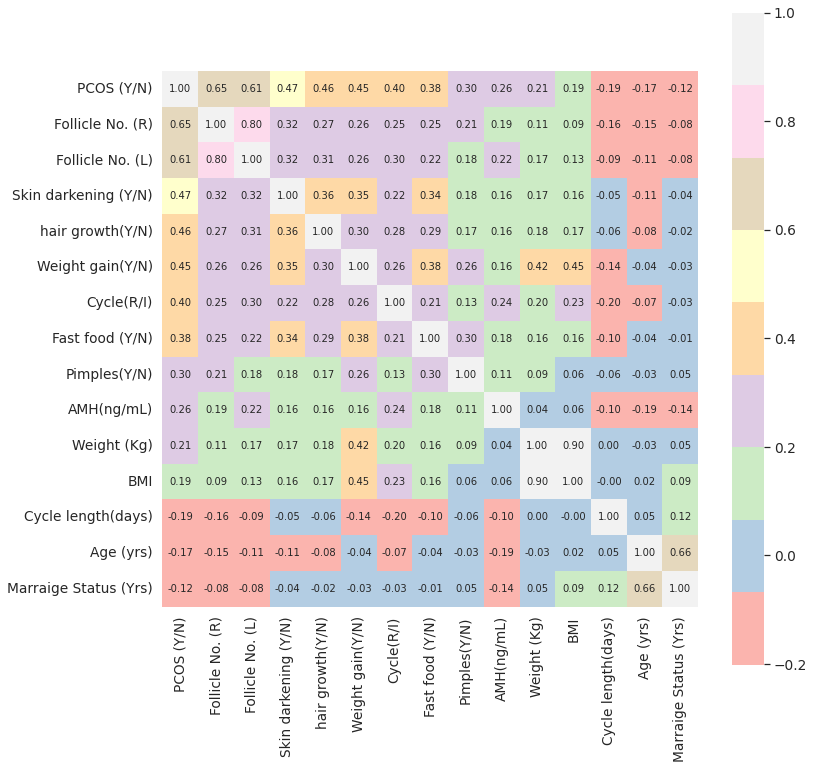

In [17]:
#Having a look at features bearing significant correlation

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index 
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

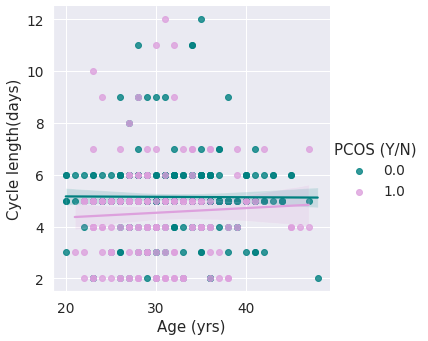

In [18]:
# Length of menstrual phase in PCOS vs normal 
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

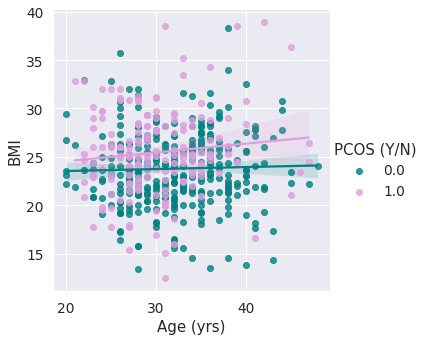

In [19]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

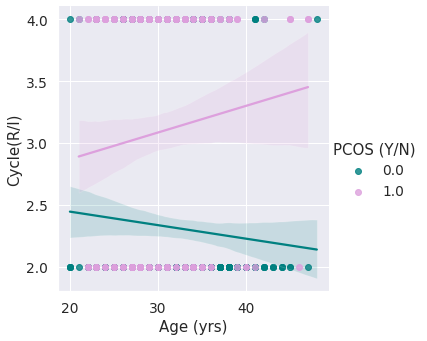

In [20]:
# cycle IR wrt age 
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

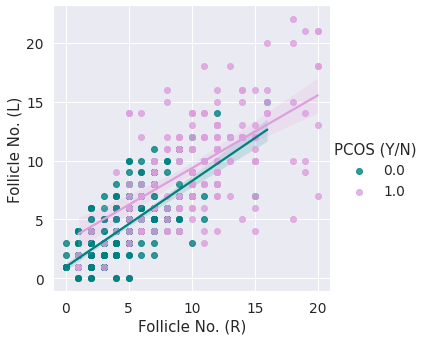

In [21]:
# Distribution of follicles in both ovaries. 
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


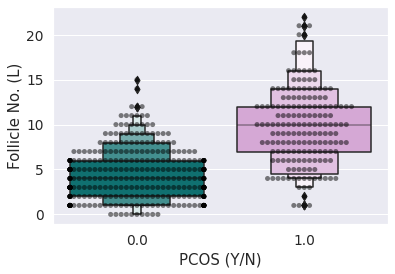

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 33.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


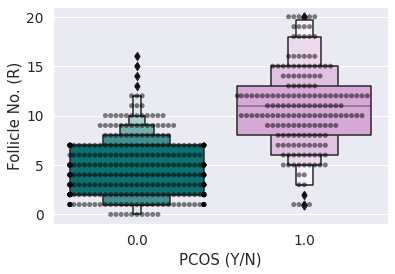

In [22]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

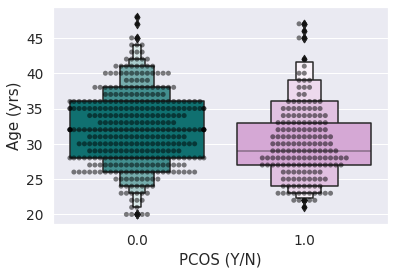

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


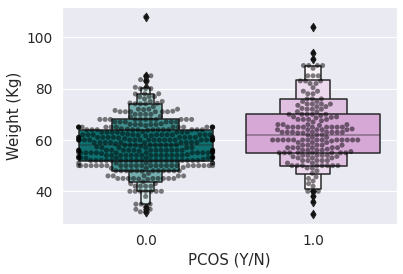

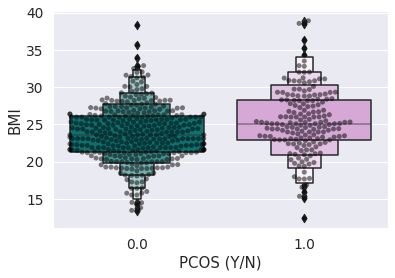

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 24.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


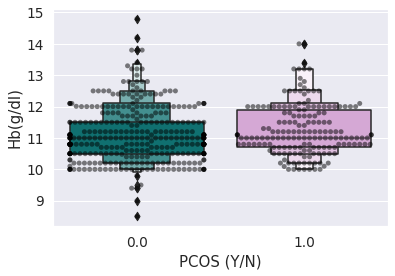

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 66.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 28.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


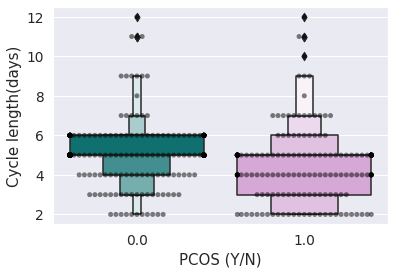

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


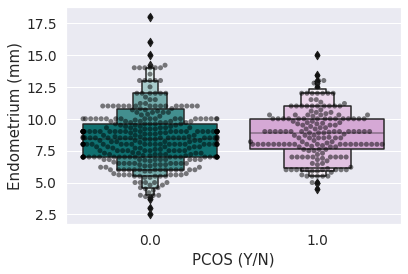

In [23]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

In [24]:
#Assiging the features (X)and target(y)

# X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
# Modify Here!
X=data[["Weight (Kg)", "BMI", "Cycle length(days)", "Weight gain(Y/N)"]]
y=data["PCOS (Y/N)"]


In [25]:
print(X.columns)

Index(['Weight (Kg)', 'BMI', 'Cycle length(days)', 'Weight gain(Y/N)'], dtype='object')


[0.25905941 0.34889098 0.2013746  0.19067501]


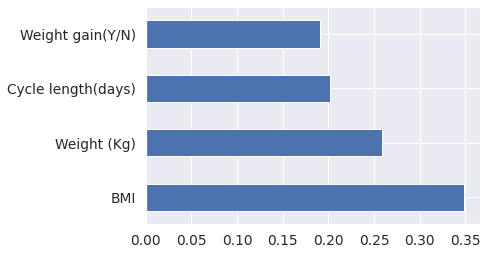

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(35).plot(kind='barh')
plt.rcParams["figure.figsize"] = (30,30)
plt.show()

In [27]:
fimp = feat_importances.nlargest(15)
df_again = data[fimp.index]
df_again

,BMI,Weight (Kg),Cycle length(days),Weight gain(Y/N)
0,19.300000,44.6,5.0,0.0
1,24.921163,65.0,5.0,0.0
2,25.270891,68.8,5.0,0.0
3,29.674945,65.0,5.0,0.0
4,20.060954,52.0,5.0,0.0
...,...,...,...,...
536,18.500000,50.0,5.0,0.0
537,25.300000,63.2,5.0,1.0
538,23.400000,54.0,6.0,0.0
539,22.200000,50.0,2.0,0.0


In [28]:
sm = SMOTEN(random_state=42)

X_sm, y_sm = sm.fit_resample(df_again, y)

X_sm=pd.DataFrame(X_sm, 
             columns=df_again.columns)
y_sm=pd.DataFrame(y_sm, columns=['PCOS (Y/N)'])


print('New balance of 1 and 0 classes (%):')
y_sm.value_counts()

New balance of 1 and 0 classes (%):


PCOS (Y/N)
0.0           353
1.0           353
dtype: int64

In [29]:
#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=12) 

In [30]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [31]:
automl.fit(X_train=X_train, y_train=y_train,X_val=X_test, y_val=y_test,**automl_settings)
# Training Process: 2minutes

[flaml.automl: 10-31 00:48:32] {2600} INFO - task = classification
[flaml.automl: 10-31 00:48:32] {2602} INFO - Data split method: stratified
[flaml.automl: 10-31 00:48:32] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-31 00:48:32] {2727} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 10-31 00:48:33] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 10-31 00:48:33] {3164} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-31 00:48:33] {3298} INFO - Estimated sufficient time budget=1716s. Estimated necessary time budget=42s.
[flaml.automl: 10-31 00:48:33] {3350} INFO -  at 0.5s,	estimator lgbm's best error=0.2642,	best estimator lgbm's best error=0.2642
[flaml.automl: 10-31 00:48:33] {3164} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-31 00:48:33] {3350} INFO -  at 0.5s,	estimator lgbm's best error=0.2642,	best estimator lgbm's best error=0.2642
[flam

In [32]:
print(automl.model.estimator)

LGBMClassifier(colsample_bytree=0.7155204344692636,
               learning_rate=0.3619385204856974, max_bin=127,
               min_child_samples=3, n_estimators=5, num_leaves=41,
               reg_alpha=0.0009765625, reg_lambda=0.013976472297408782,
               verbose=-1)


In [33]:
rfc = lgb.LGBMClassifier(learning_rate=0.3374329294340775, max_bin=1023,
               min_child_samples=8, n_estimators=9, num_leaves=9,
               reg_alpha=0.0009765625, reg_lambda=4.305658316786484,
               verbose=-1)
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.75


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

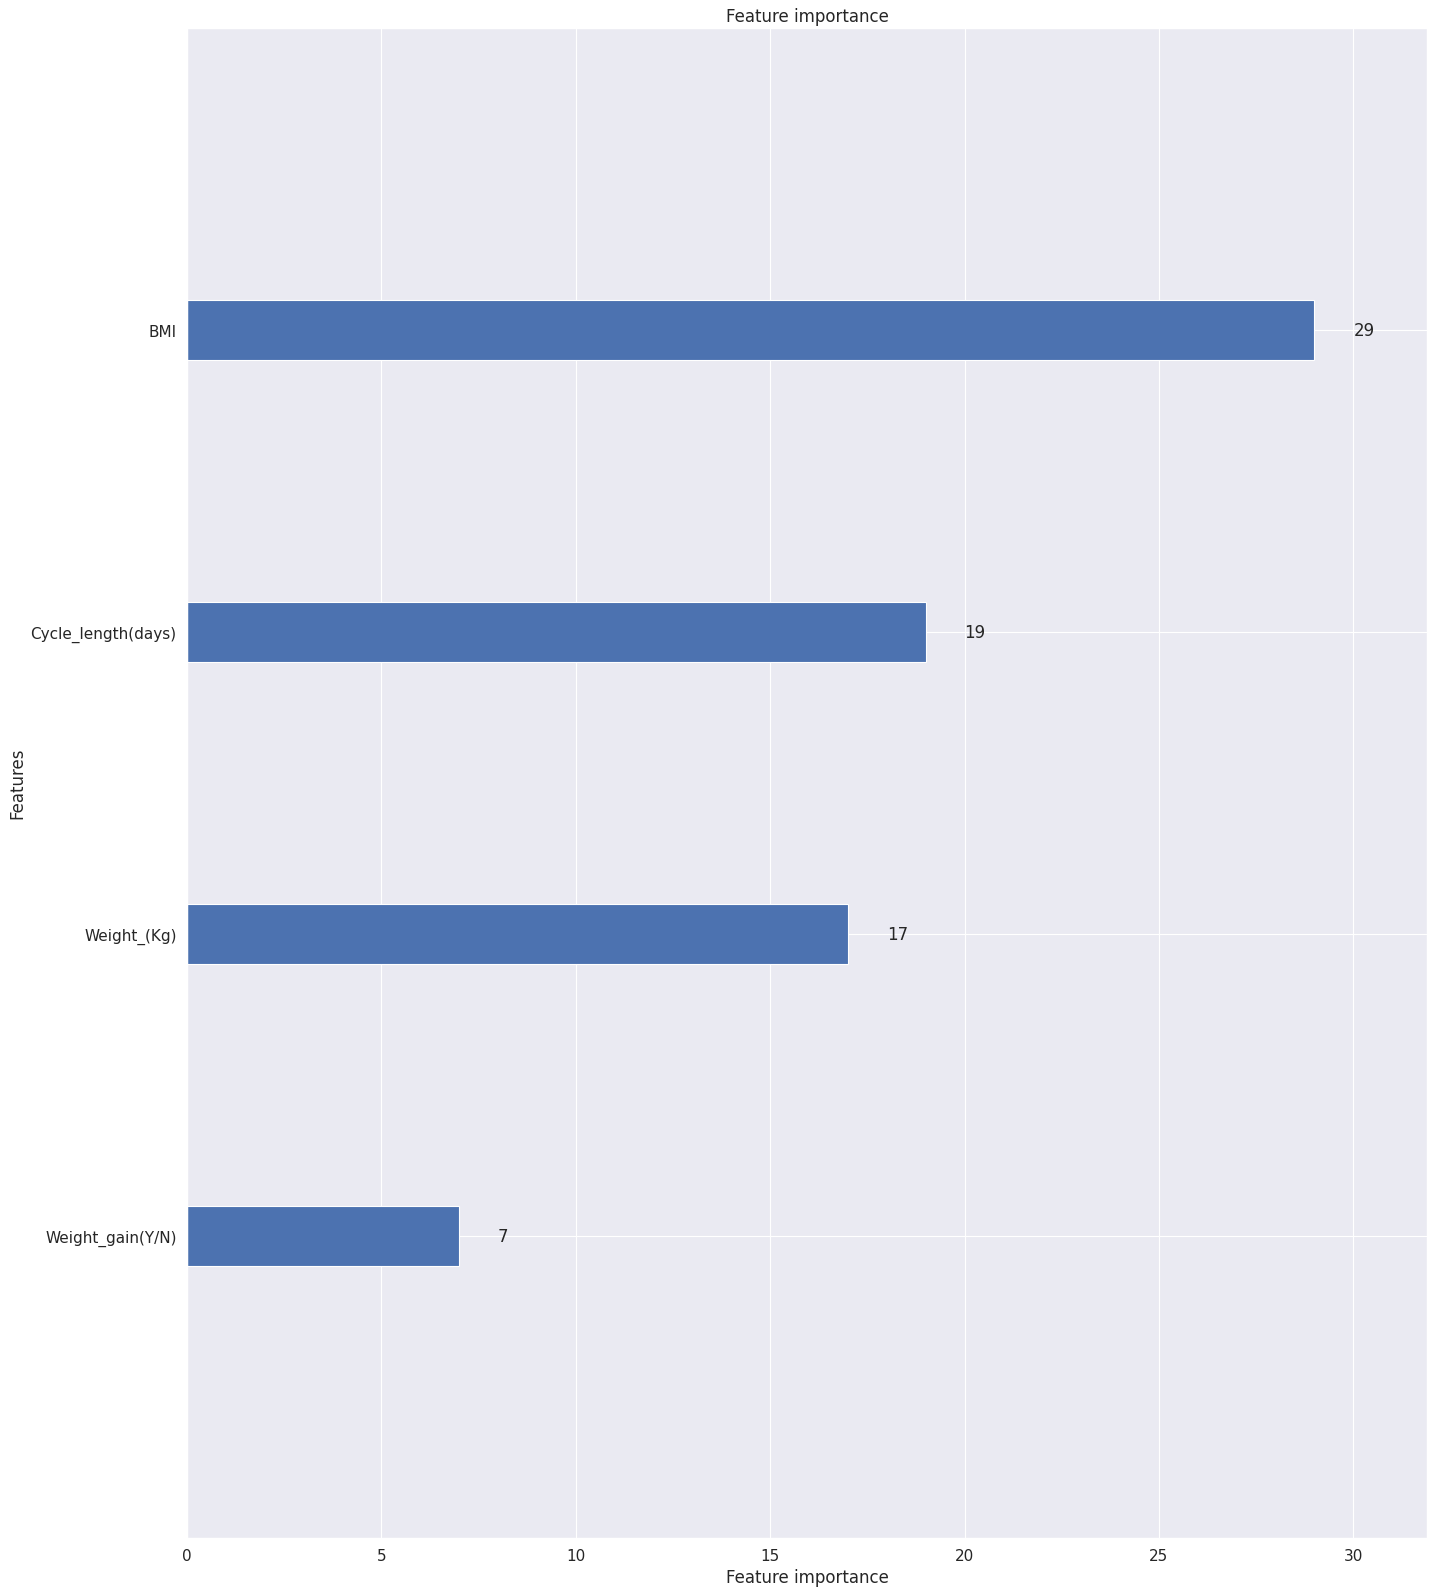

In [34]:
lgb.plot_importance(rfc, dpi=80, figsize=(20,25)) # Explainable AI

In [35]:
classi_report = classification_report(y_test, pred_rfc)
print(classi_report)

              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       104
         1.0       0.80      0.69      0.74       108

    accuracy                           0.75       212
   macro avg       0.75      0.75      0.75       212
weighted avg       0.76      0.75      0.75       212



<AxesSubplot:>

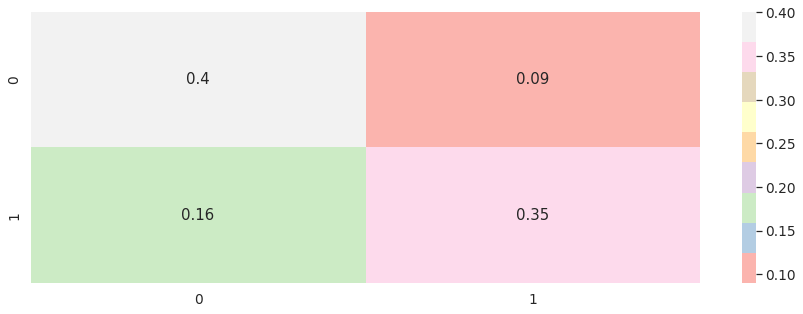

In [36]:
# cofusion matrix
plt.subplots(figsize=(15,5))
cf_matrix = confusion_matrix(y_test, pred_rfc)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

In [37]:
save_to = '{}.txt'.format('pcos_model')
rfc.booster_.save_model(save_to)

In [38]:
# **<span style="color:teal;"> If you liked this Notebook, please do upvote.</span>**

# **<span style="color:teal;"> If you have any suggestions or questions, I am all ears!</span>**

# **<span style="color:teal;">Best Wishes!</span>**

# <p style="background-color:teal;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">END</p>